In [1]:
import sys
sys.path.append('../../')
sys.path.append('../')

dataset_path = "../dataset"
preprocessed_dataset_path = "../dataset/preprocessed_dataset"
codes_path = '../../codes/'
from codes.docs.analysis import data_preprocessing, genetic_file_preprocess
from codes.docs.analysis.nimagen import genes, stats, visualisation

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.io
import glob
from collections import defaultdict
import tqdm
import re
%matplotlib inline

In [2]:
european_volumetric_dataset_term = pd.read_csv('../../dataset/preprocessed_dataset/imaging_data/log_file/rel3/volumetric/european_volumetric_df_rel3_batch2.csv')

european_volumetric_dataset_term = european_volumetric_dataset_term[(european_volumetric_dataset_term['radiology_score']<5)&(european_volumetric_dataset_term['radiology_low_image_quality']==False)]

PRS_imputed_Grove = genetic_file_preprocess.Cohort.preprocess_PRSice_PRS_Anc_files('../../dataset/PRS/asd/imputed_data/ASD_nodups_euro_batch2_imputed.gwas.all_score',column_prefix='ASD_imputed_PRS_')

european_volumetric_dataset_term = european_volumetric_dataset_term.merge(PRS_imputed_Grove,on='ID')

In [3]:
available_dwi = pd.read_csv('../../codes/FBA/subject_lists/available_dwi.txt',header=None,names=['ID','Session'])
available_dwi['ID/Ses'] = available_dwi['ID']+'/'+available_dwi['Session'].astype('str')

def concat_files(files):
    to_return = pd.DataFrame()
    for variable,file in files.items():
        temp = pd.read_csv(file,delim_whitespace=True,header=None)
        temp.columns = ['ID/Ses']+[f'wm_{i}_{variable}' for i in range(94,148)]
        temp = temp.drop_duplicates('ID/Ses')
        temp['ID/Ses'] = temp['ID/Ses'].apply(lambda x: x.replace('_','/'))
        temp = temp.set_index('ID/Ses')
        to_return = pd.concat([to_return,temp],axis=1)
    return to_return.reset_index()

tract_metrics = concat_files({'fd':'../../codes/FBA/output_ASD/aba/mean_fd.txt',
                     'log_fc':'../../codes/FBA/output_ASD/aba/mean_log_fc.txt',
                     'fdc':'../../codes/FBA/output_ASD/aba/mean_fdc.txt'})

df = european_volumetric_dataset_term.copy()

ancestry = [f'euro_Anc_PC{i}'
            for i in range(1, 4)]  # remove any ancestry outliers

df = stats.MassUnivariate.remove_outliers(
    df,
    col=ancestry,
    threshold=3.5,
    remove_schemes='any',
    percentage_of_outlier=0.1)

df['ID/Ses'] = 'sub-'+df['ID']+'/ses-'+df['Session'].astype('str')

df = stats.MassUnivariate.remove_outliers(
    df,
    col=['WM','GM','TBV','ICV'],
    threshold=3.5,
    remove_schemes='any')

df = pd.merge(df,tract_metrics,on=['ID/Ses'],how='inner')

In [4]:
log_fc_res = pd.read_csv('tract_based_mean_log_fc.csv')
fd_res = pd.read_csv('tract_based_mean_fd.csv')
fdc_res = pd.read_csv('tract_based_mean_fdc.csv')

In [13]:
log_fc_res_best = log_fc_res[(log_fc_res['threshold'] == 'ASD_imputed_PRS_Pt_0.01') & (log_fc_res['PRS_pval']<0.05/6)].copy()
log_fc_res_best['tract'] = log_fc_res_best['Connection'].apply(lambda x: data_preprocessing.Diffusion.WM_parcellation.get_wm_parcellation()[x.replace('_log_fc','')]['abbr'])


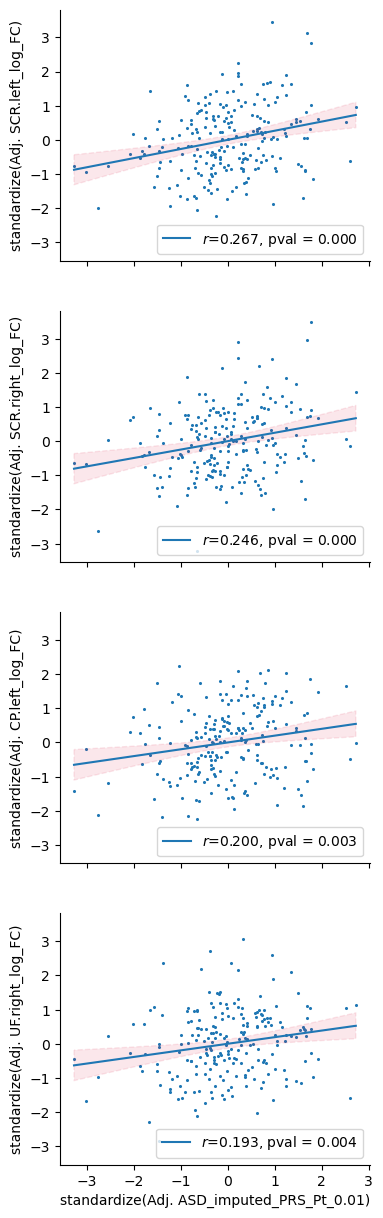

In [67]:
fig,axes = plt.subplots(4,1,figsize=(4,15),sharex=True,sharey=True)
for idx,(ax,connection,name) in enumerate(zip(axes,['wm_102_log_fc','wm_103_log_fc','wm_124_log_fc','wm_140_log_fc'],
                             ['SCR.left','SCR.right','CP.left','UF.right'])):
    visualisation.SimplePlots.Scatter(y=connection,
                                      x='ASD_imputed_PRS_Pt_0.01',
                                      data=df,
                                      adjust_covar={'y':['sex','GA','PMA','TBV'],
                                                   'x':ancestry},ax=ax,fig=fig,legend_loc='lower right',
                                     ylabel=f'{name}_log_FC')
    if idx<3:
        ax.set_xlabel('')
sns.despine()

In [5]:
r_squared_dict = defaultdict(dict)
for component in ['wm_102','wm_103']:
    for metric in ['fdc','fd','log_fc']:
        r_squared_dict[component][metric] = []
        for threshold in tqdm.tqdm([i for i in df.columns if 'ASD_imputed_PRS' in i]):
            if metric == 'fd':
                cont_independentVar_cols = [threshold,'GA','PMA']+ancestry
            else:
                cont_independentVar_cols = [threshold,'GA','PMA','TBV']+ancestry
            temp = stats.MassUnivariate.calculate_R_squared_explained(
                df,
                col_to_drop=[threshold],
                cat_independentVar_cols=['sex'],
                cont_independentVar_cols=cont_independentVar_cols,
                dependentVar_cols=[f'{component}_{metric}'])
            r_squared_dict[component][metric].append(temp)

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 22.59it/s]


In [6]:
r_squared_df = pd.DataFrame()
for name,component in zip(['SCR.L','SCR.R'],['wm_102','wm_103']):
    for metric in ['fd','log_fc','fdc']:
        temp = pd.DataFrame({'R2':r_squared_dict[component][metric]})
        temp['tract'] = name
        temp['type'] = metric
        temp['thresholds'] = [i for i in df.columns if 'ASD_imputed_PRS' in i]
        r_squared_df = pd.concat([r_squared_df,temp])

In [7]:
# r_squared_df = pd.DataFrame()
# for metric in ['fd','fdc','log_fc']:
#     temp_metric = pd.DataFrame()
#     for name,component in zip(['SCR.L','SCR.R'],['wm_102','wm_103']):
#         temp_metric = pd.concat([temp_metric,pd.DataFrame({component:r_squared_dict[component][metric]})],axis=1)
#     temp_metric['type'] = metric
#     temp_metric['thresholds'] = [i for i in df.columns if 'ASD_imputed_PRS' in i]
#     r_squared_df = pd.concat([r_squared_df,temp_metric])

TypeError: matplotlib.axes._axes.Axes.bar() got multiple values for keyword argument 'bottom'

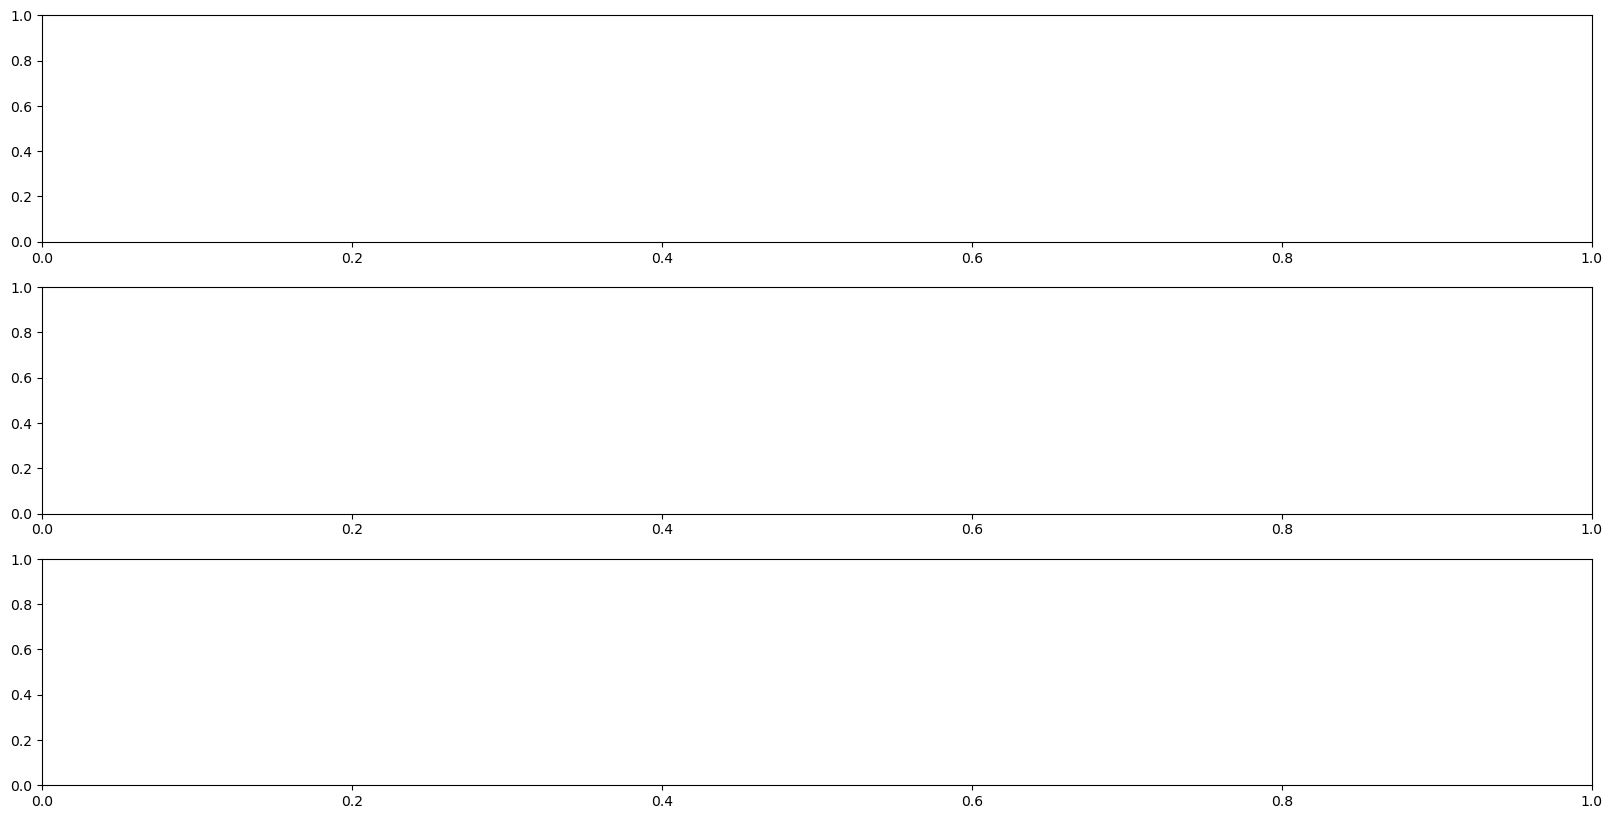

In [8]:
fig,axes = plt.subplots(3,1,figsize=(20,10))
all_bars_vals = visualisation.SimplePlots.Bar(x='thresholds',y='R2',hue='tract',data=r_squared_df,
                          separateby='type',
                         order={'x':[i for i in df.columns if 'ASD_imputed_PRS' in i],
                               'hue':['SCR.L','SCR.R']},
                         figsize=(15,5),barwidth=0.5,ylabel_pos=(-.015,.6),ylabel='R2',plot_label='type',
                             xlabel='thresholds',fig=fig,ax=axes)
plt.tight_layout()
sns.despine()
# plt.savefig('mean_fixel.png')

In [11]:
test = pd.DataFrame(all_bars_vals)

In [60]:
r_squared_df[r_squared_df['type']=='fd']

,wm_102,wm_103,type
0,0.002226,0.005645,fd
1,0.001650,0.005617,fd
2,0.001379,0.000454,fd
3,0.002606,0.002639,fd
4,0.006509,0.004686,fd
5,0.000771,0.001392,fd
6,0.002859,0.005457,fd
7,0.004762,0.006976,fd
8,0.001804,0.005363,fd
9,0.001156,0.004480,fd


array([<AxesSubplot:title={'center':'wm_102'}, ylabel='thresholds'>,
       <AxesSubplot:title={'center':'wm_103'}, ylabel='thresholds'>],
      dtype=object)

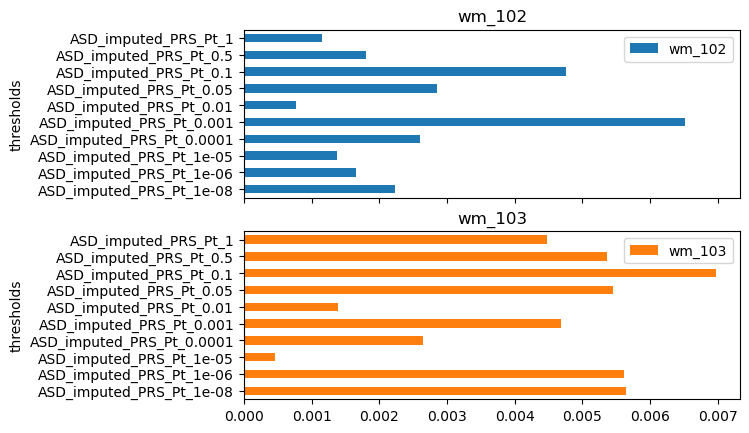

In [64]:
r_squared_df[r_squared_df['type']=='fd'].plot(kind='barh',x='thresholds')

In [10]:
order={'x':[1,2,3]}

In [12]:
set(['a', 'b']).issubset(['a', 'b', 'c'])order['x']

[1, 2, 3]

In [15]:
current_separateby_index = np.where(separateby==uniq_separateby[0])

In [26]:
temp_x = x[current_separateby_index]
temp_y = y[current_separateby_index]
temp_x_pos = np.arange(len(np.unique(temp_x)))
temp_hue = hue[current_separateby_index]

In [32]:
def get_unique(x:np.ndarray):
    #conveninece function to return unique values but in preserved order
    if isinstance(x,list):
        new_x = np.ndarray(x)
    else:
        new_x = x.copy()
    _,idx = np.unique(new_x,return_index=True)
    return new_x[np.sort(idx)]

In [35]:
unique_hue = get_unique(all_bars_vals['hue'])

In [10]:
from itertools import chain

In [12]:
list(chain.from_iterable(['abc','abc']))

['a', 'b', 'c', 'a', 'b', 'c']

In [9]:
to_plot_dictionary

defaultdict(dict,
            {'o': {'e': {'w': defaultdict(list,
                           {'y': 0, 'colorby': 0, 'y2': 0}),
               '2': defaultdict(list, {'y': 0, 'colorby': 0, 'y2': 0}),
               '_': defaultdict(list, {'y': 0, 'colorby': 0, 'y2': 0}),
               '3': defaultdict(list, {'y': 0, 'colorby': 0, 'y2': 0}),
               '1': defaultdict(list,
                           {'y': 0.010385404704513657, 'colorby': 0, 'y2': 0}),
               'm': defaultdict(list, {'y': 0, 'colorby': 0, 'y2': 0}),
               '0': defaultdict(list, {'y': 0, 'colorby': 0, 'y2': 0})},
              'i': {'w': defaultdict(list, {'y': 0, 'colorby': 0, 'y2': 0}),
               '2': defaultdict(list, {'y': 0, 'colorby': 0, 'y2': 0}),
               '_': defaultdict(list, {'y': 0, 'colorby': 0, 'y2': 0}),
               '3': defaultdict(list, {'y': 0, 'colorby': 0, 'y2': 0}),
               '1': defaultdict(list, {'y': 0, 'colorby': 0, 'y2': 0}),
               'm': defaultdi

In [11]:
from itertools import chain,product

In [18]:
list(chain.from_iterable(separateby))

['fd',
 'fd',
 'fd',
 'fd',
 'fd',
 'fd',
 'fd',
 'fd',
 'fd',
 'fd',
 'log_fc',
 'log_fc',
 'log_fc',
 'log_fc',
 'log_fc',
 'log_fc',
 'log_fc',
 'log_fc',
 'log_fc',
 'log_fc',
 'fdc',
 'fdc',
 'fdc',
 'fdc',
 'fdc',
 'fdc',
 'fdc',
 'fdc',
 'fdc',
 'fdc',
 'fd',
 'fd',
 'fd',
 'fd',
 'fd',
 'fd',
 'fd',
 'fd',
 'fd',
 'fd',
 'log_fc',
 'log_fc',
 'log_fc',
 'log_fc',
 'log_fc',
 'log_fc',
 'log_fc',
 'log_fc',
 'log_fc',
 'log_fc',
 'fdc',
 'fdc',
 'fdc',
 'fdc',
 'fdc',
 'fdc',
 'fdc',
 'fdc',
 'fdc',
 'fdc']

In [16]:
set(product(separateby,x))

TypeError: unhashable type: 'numpy.ndarray'

In [9]:
x,y,colorby,separateby,hue = visualisation.SimplePlots.Bar(x='thresholds',y='R2',hue='tract',data=r_squared_df,separateby='type')

In [11]:
y2=[0 for i in range(len(x))]

In [54]:
from itertools import chain,product

In [13]:
def dictionary_merge(dict1,dict2):
#convenience function to merge nested dictionary together
    for key in dict2:
        if key in dict1:
            if isinstance(dict1[key],dict) and isinstance(dict2[key],dict):
                dictionary_merge(dict1[key],dict2[key])
        else:
            dict1[key]=dict2[key]
    return dict1

In [58]:
def groupby(*args,**kwargs):
    args = [list(chain.from_iterable(i)) for i in args if i is not None]
    kwargs = {k:v for k,v in kwargs.items() if v is not None}
    all_unique_keys = [tuple(set(i)) for i in args]
    all_possible_keys = product(*all_unique_keys)
    all_values = list(kwargs.keys())

    return all_possible_keys

In [59]:
args = groupby(separateby,x,hue,y=y)

In [50]:
visualisation.SimplePlots.Groupby.groupby(separateby,x,hue,y=y,colorby=colorby,y2=y2)

TypeError: unhashable type: 'numpy.ndarray'

In [15]:
to_plot = pd.concat([test[['Connection','PRS_pval','threshold']],
          test2[['Connection','PRS_pval','threshold']]]).copy()

to_plot = to_plot[to_plot['threshold'].isin([i for i in df.columns if 'ASD_CS' in i or 'ASD_PRS_PC1' in i])].copy()

# to_plot = pd.concat([test[['Connection','PRS_pval','threshold']],
#           test2[['Connection','PRS_pval','threshold']]]).copy()
# to_plot = test[['Connection','PRS_pval','threshold']].copy()
to_plot['type'] = to_plot['Connection'].apply(lambda x: x.split('_mean')[0])

to_plot['Tract'] = to_plot['Connection'].apply(lambda x: '+'.join(x.split('_mean')[1].split('_')[1:]))

# visualisation.SimplePlots.Bar(x='threshold',y='PRS_pval',hue='Connection',data=to_plot[to_plot['type']=='log_FC'],
#                               order={'x':[i for i in tract_volumes.columns if 'ASD_PRS' in i]},
#                               yscalelog=True,hline=0.05,rotation_x=90)

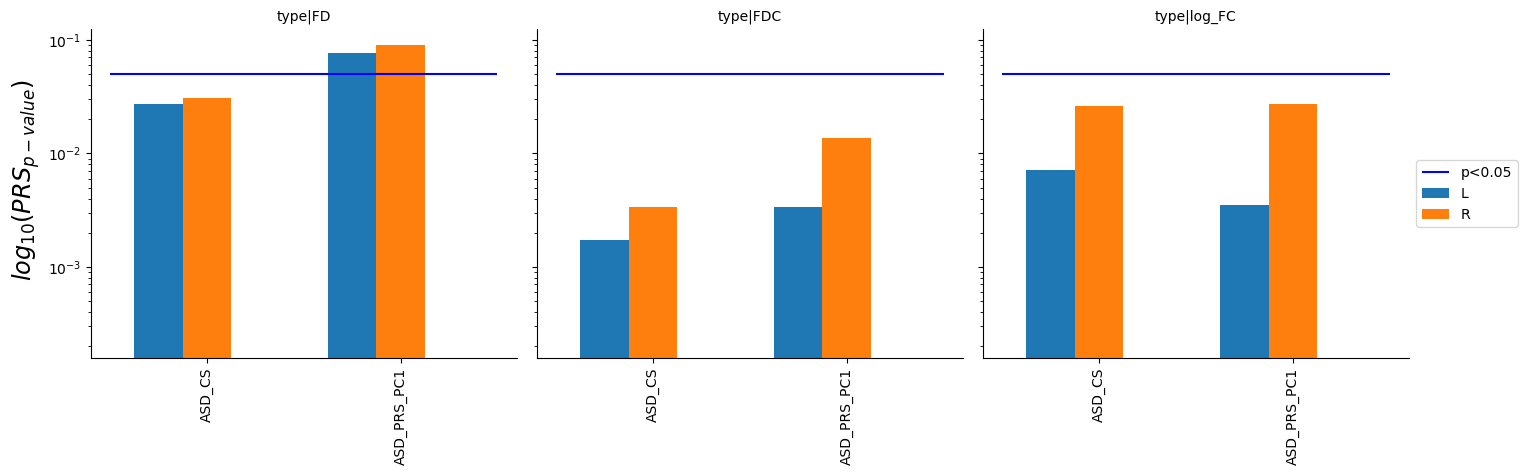

In [17]:
visualisation.SimplePlots.Bar(x='threshold',y='PRS_pval',hue='Tract',data=to_plot,
                          separateby='type',
                         order={
                               'hue':['L','R']},yscalelog=True,
                         ylabel='$log_{10}(PRS_{p-value})$',rotation_x=90,
                              hline=[0.05],hline_label=['p<0.05'],
                         figsize=(15,5),barwidth=0.5,xlabel=None,ylabel_pos=(-.015,.6))
plt.tight_layout()
sns.despine()

In [51]:
0.05/6

0.008333333333333333

In [ ]:
visualisation.SimplePlots.Scatter(y='mean_',x='ASD_PRS_Pt_0.01',data=df,
                                 adjust_covar={'y':['TBV','GA','PMA','sex'],'x':ancestry})

In [55]:
log_fc_mean_L_R = pd.read_csv('../../codes/FBA/output_ASD/tractography/individual_tracts/cst_L_R/mean-log_fc-cst_L_R-significant.txt',header=None)

In [58]:
log_fc_mean_L_R.columns = ['log_FC_mean_significant_fixels']

In [61]:
df = pd.concat([df,log_fc_mean_L_R],axis=1)

<AxesSubplot:xlabel='standardize(Adj. ASD_PRS_Pt_0.01)', ylabel='standardize(Adj. log_FC_mean_significant_fixels)'>

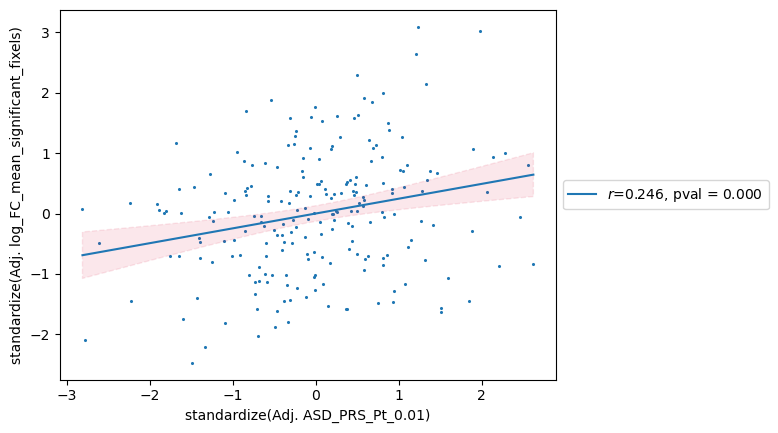

In [67]:
visualisation.SimplePlots.Scatter(y='log_FC_mean_significant_fixels',x='ASD_PRS_Pt_0.01',data=df,
                                 adjust_covar={'y':['TBV','GA','PMA','sex'],'x':ancestry})